## analyze LFP from DR recordings

In [2]:
#Import packages
import pandas as pd
import h5py
import numpy as np
import scipy as sp
import scipy.signal as sg
import scipy.stats as st
import xarray as xr
import os
import matplotlib.pyplot as plt
from matplotlib import patches
import ast
import glob
import re

from DR_analysis_utils import Session, makePSTH, make_neuron_time_trials_tensor 
from DR_analysis_utils import compute_smoothed_response_rate, compute_block_modulation

%matplotlib notebook

In [ ]:
# %load_ext autoreload
# %autoreload 2

In [3]:
main_path = [
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_626791_20220815\processed",
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_626791_20220816\processed",
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_626791_20220817\processed",
    
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_636766_20230123\processed", 
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_636766_20230124\processed", 
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_636766_20230125\processed", 
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_636766_20230126\processed", 
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_644864_20230130\processed",
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_644864_20230131\processed", 
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_644864_20230201\processed", 
    r"\\allen\programs\mindscope\workgroups\np-exp\PilotEphys\Task 2 pilot\DRpilot_644864_20230202\processed",
#     r"\\allen\programs\mindscope\workgroups\np-exp\PilotEphys\Task 2 pilot\DRpilot_644866_20230207\processed", 
    #some error with this one's processing ^
    r"Y:\DRpilot_644866_20230208\processed",
    r"Y:\DRpilot_644866_20230209\processed",
    r"Y:\DRpilot_644866_20230210\processed",
    r"Y:\DRpilot_644867_20230220\processed",
    r"Y:\DRpilot_644867_20230221\processed",
    r"Y:\DRpilot_644867_20230222\processed",
    r"Y:\DRpilot_644867_20230223\processed",
    r"Y:\DRpilot_649943_20230213\processed", 
    r"Y:\DRpilot_649943_20230214\processed",
    r"Y:\DRpilot_649943_20230215\processed",
    r"Y:\DRpilot_649943_20230216\processed",
]

In [4]:
sel_session=20
session=Session(path=main_path[sel_session])
session.assign_unit_areas()


probeA areas found
probeB areas found
probeC areas found
probeD areas found
probeE areas found
probeF areas found


In [6]:
session.good_units.query('probe == "A"')['area'].unique()

array(['CP', 'N/A', 'MOp6b', 'MOp6a', 'MOs6a', 'MOs5', 'MOs2/3'],
      dtype=object)

In [7]:
#LFP timestamps

probe='A'

lfp_path=session.metadata['syncData'][probe]['dirName'].replace('AP','LFP')
lfp_samples_path=os.path.join(lfp_path,"sample_numbers.npy")

lfp_samples=np.load(lfp_samples_path)
lfp_samples=lfp_samples-np.min(lfp_samples)

lfp_timestamps = lfp_samples/(session.metadata['syncData'][probe]['LFPsampleRate']) - session.metadata['syncData'][probe]['shift']
lfp_timestamps

array([  17.60945132,   17.60985132,   17.61025131, ..., 4828.65518855,
       4828.65558855, 4828.65598855])

In [ ]:
# remapping_pattern = np.array([0, 12, 1, 13, 2, 14, 3, 15, 4, 16, 5, 17, 6, 18, 7, 19, 
#               8, 20, 9, 21, 10, 22, 11, 23, 24, 36, 25, 37, 26, 38,
#               27, 39, 28, 40, 29, 41, 30, 42, 31, 43, 32, 44, 33, 45, 34, 46, 35, 47])

# channel_order = np.concatenate([remapping_pattern + 48*i for i in range(0,8)])

In [8]:
#LFP signal

lfp_signal=np.memmap(os.path.join(lfp_path,'continuous.dat'),dtype='int16',mode='r')
lfp_signal=np.reshape(lfp_signal, (int(lfp_signal.size / 384), 384))

lfp_channel_ind=np.arange(0,384)

sample_frequency = session.metadata['syncData'][probe]['LFPsampleRate']


In [9]:
#load confirmed surface channels
surface_channels=pd.read_csv(r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\DRpilot_surface_estimates.csv")

In [ ]:
# surface_channels
# 2**13

In [10]:
#for every trial, extract & normalize LFP

nchannels=384
nfft=2**12

channels = np.arange(nchannels).astype('int')

#get surface channel for this session + probe
mouse_session=str(session.metadata['mouseID'])+'_'+str(session.metadata['ephys_session_num'])
probe_surface_channel = int(surface_channels.query('session ==  @mouse_session')['probe'+probe].values)

lfp_tensor=np.zeros((2500*2,384,len(session.trials)),dtype='int16')
power = np.zeros((int(nfft/2+1), nchannels, len(session.trials)))

#loop through all trials
for tt, trial in session.trials.iterrows():
    startPt = int((trial['stimStartTime']-1)*sample_frequency)
    endPt = startPt + int(sample_frequency)*2
    
    channel_range = [probe_surface_channel, probe_surface_channel+20]
    
    chunk = np.copy(lfp_signal[startPt:endPt,channels])

    for ch in np.arange(nchannels):
        chunk[:,ch] = chunk[:,ch] - np.median(chunk[:,ch],0)

    for ch in np.arange(nchannels):
        chunk[:,ch] = chunk[:,ch] - np.median(chunk[:,channel_range[0]:channel_range[1]],1)

        sample_frequencies, Pxx_den = sg.welch(chunk[0:2500,ch], fs=sample_frequency, nfft=nfft)
        power[:,ch,tt] = Pxx_den
        
    lfp_tensor[:,:,tt]=chunk
    
    print('trial ',tt,' done')

trial  0  done
trial  1  done
trial  2  done
trial  3  done
trial  4  done
trial  5  done
trial  6  done
trial  7  done
trial  8  done
trial  9  done
trial  10  done
trial  11  done
trial  12  done
trial  13  done
trial  14  done
trial  15  done
trial  16  done
trial  17  done
trial  18  done
trial  19  done
trial  20  done
trial  21  done
trial  22  done
trial  23  done
trial  24  done
trial  25  done
trial  26  done
trial  27  done
trial  28  done
trial  29  done
trial  30  done
trial  31  done
trial  32  done
trial  33  done
trial  34  done
trial  35  done
trial  36  done
trial  37  done
trial  38  done
trial  39  done
trial  40  done
trial  41  done
trial  42  done
trial  43  done
trial  44  done
trial  45  done
trial  46  done
trial  47  done
trial  48  done
trial  49  done
trial  50  done
trial  51  done
trial  52  done
trial  53  done
trial  54  done
trial  55  done
trial  56  done
trial  57  done
trial  58  done
trial  59  done
trial  60  done
trial  61  done
trial  62  done
tr

trial  489  done
trial  490  done
trial  491  done
trial  492  done
trial  493  done
trial  494  done
trial  495  done
trial  496  done
trial  497  done
trial  498  done
trial  499  done
trial  500  done
trial  501  done
trial  502  done
trial  503  done
trial  504  done
trial  505  done
trial  506  done
trial  507  done
trial  508  done
trial  509  done
trial  510  done
trial  511  done
trial  512  done
trial  513  done
trial  514  done
trial  515  done
trial  516  done
trial  517  done
trial  518  done
trial  519  done
trial  520  done
trial  521  done
trial  522  done
trial  523  done
trial  524  done
trial  525  done
trial  526  done
trial  527  done
trial  528  done
trial  529  done
trial  530  done
trial  531  done
trial  532  done
trial  533  done
trial  534  done
trial  535  done
trial  536  done
trial  537  done
trial  538  done
trial  539  done
trial  540  done
trial  541  done
trial  542  done
trial  543  done
trial  544  done
trial  545  done
trial  546  done


In [ ]:
# #find power in pre-stim time for each trial

# power = np.zeros((int(nfft/2+1), nchannels, len(session.trials)))

# for tt in range(0,len(session.trials)):
    
#     for ch in np.arange(nchannels):

#         sample_frequencies, Pxx_den = sg.welch(lfp_tensor[2500:5000,ch,tt], fs=sample_frequency, nfft=nfft)
#         power[:,ch,tt] = Pxx_den

In [11]:
# FA vs. CR trials
#start w sound block only
CR_trials = session.trials.query('trialStimID=="vis1" and trialstimRewarded=="sound1" and trial_response==False').index.values
FA_trials = session.trials.query('trialStimID=="vis1" and trialstimRewarded=="sound1" and trial_response==True').index.values

HIT_trials = session.trials.query('trialStimID=="vis1" and trialstimRewarded=="vis1" and trial_response==True').index.values


CR_power = np.nanmedian(power[:,:,CR_trials],2)
FA_power = np.nanmedian(power[:,:,FA_trials],2)
HIT_power = np.nanmedian(power[:,:,HIT_trials],2)

CR_lfp = np.nanmedian(lfp_tensor[:,:,CR_trials],2)
FA_lfp = np.nanmedian(lfp_tensor[:,:,FA_trials],2)
HIT_lfp = np.nanmedian(lfp_tensor[:,:,HIT_trials],2)

In [12]:
chans=session.channels[probe]
session.channels[probe]['region'][session.channels[probe].query('region.isnull()').index.values]=''

area_borders=np.where(chans['region'].iloc[:-1].values!=
                       chans['region'].iloc[1:].values)[0]
all_edges=np.hstack([0,area_borders,len(chans)])
midpoints=all_edges[:-1]+(all_edges[1:]-all_edges[:-1])/2
area_labels=chans['region'].iloc[midpoints.astype('int')].values

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_6552\3159761393.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session.channels[probe]['region'][session.channels[probe].query('region.isnull()').index.values]=''


In [ ]:
# session.channels[probe].query('region.isnull()')

In [29]:
MOs_channels=session.channels[probe]['region'].str.contains('MOs').values

<IPython.core.display.Javascript object>


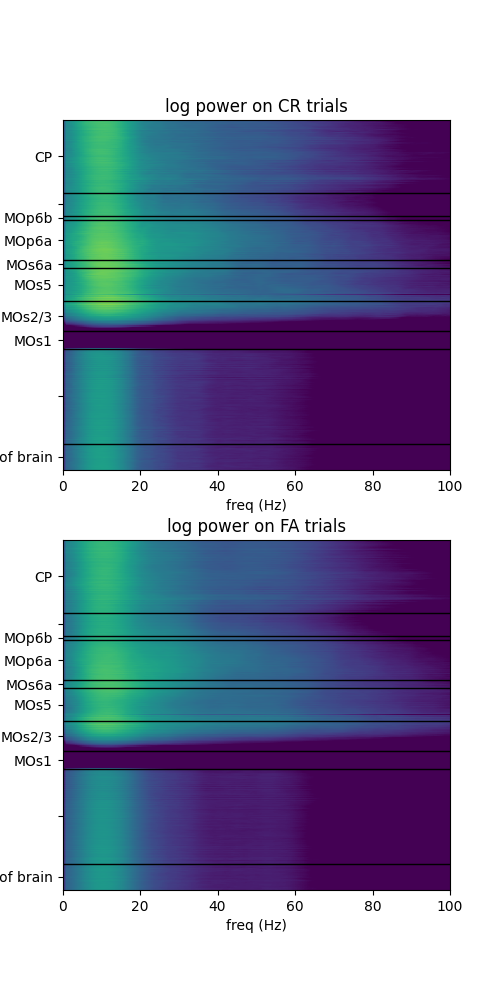

[Text(0, 344.0, 'CP'),
 Text(0, 291.5, ''),
 Text(0, 276.5, 'MOp6b'),
 Text(0, 252.0, 'MOp6a'),
 Text(0, 226.0, 'MOs6a'),
 Text(0, 203.5, 'MOs5'),
 Text(0, 168.5, 'MOs2/3'),
 Text(0, 142.5, 'MOs1'),
 Text(0, 81.0, ''),
 Text(0, 14.5, 'out of brain')]

In [33]:
fig,ax=plt.subplots(2,1,figsize=(5,10))

cr_im=ax[0].imshow(np.log10(CR_power).T,aspect='auto',vmin=np.log10(100),vmax=np.log10(7000),
                   extent=(sample_frequencies[0],sample_frequencies[-1],0,384))
ax[0].set_title('log power on CR trials')
ax[0].set_xlim([0,100])
ax[0].set_ylabel('channel')
ax[0].set_xlabel('freq (Hz)')

ax[0].hlines(384-area_borders,xmin=0,xmax=100,
                   color='k',linewidth=1)
ax[0].set_yticks(384-midpoints)
ax[0].set_yticklabels(area_labels)

fa_im=ax[1].imshow(np.log10(FA_power).T,aspect='auto',vmin=np.log10(100),vmax=np.log10(7000),
                   extent=(sample_frequencies[0],sample_frequencies[-1],0,384))
ax[1].set_title('log power on FA trials')
ax[1].set_xlim([0,100])
ax[1].set_ylabel('channel')
ax[1].set_xlabel('freq (Hz)')

ax[1].hlines(384-area_borders,xmin=0,xmax=100,
                   color='k',linewidth=1)
ax[1].set_yticks(384-midpoints)
ax[1].set_yticklabels(area_labels)

<IPython.core.display.Javascript object>


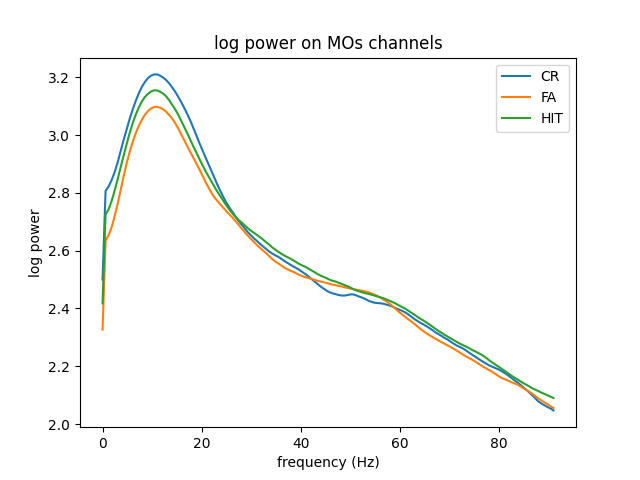

Text(0.5, 1.0, 'log power on MOs channels')

In [31]:
fig,ax=plt.subplots(1,1)
ax.plot(sample_frequencies[:150],np.log10(np.nanmean(CR_power[:150,MOs_channels],1)).T)
ax.plot(sample_frequencies[:150],np.log10(np.nanmean(FA_power[:150,MOs_channels],1)).T)
ax.plot(sample_frequencies[:150],np.log10(np.nanmean(HIT_power[:150,MOs_channels],1)).T)
ax.legend(['CR','FA','HIT'])

ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('log power')
ax.set_title('log power on MOs channels')

<IPython.core.display.Javascript object>


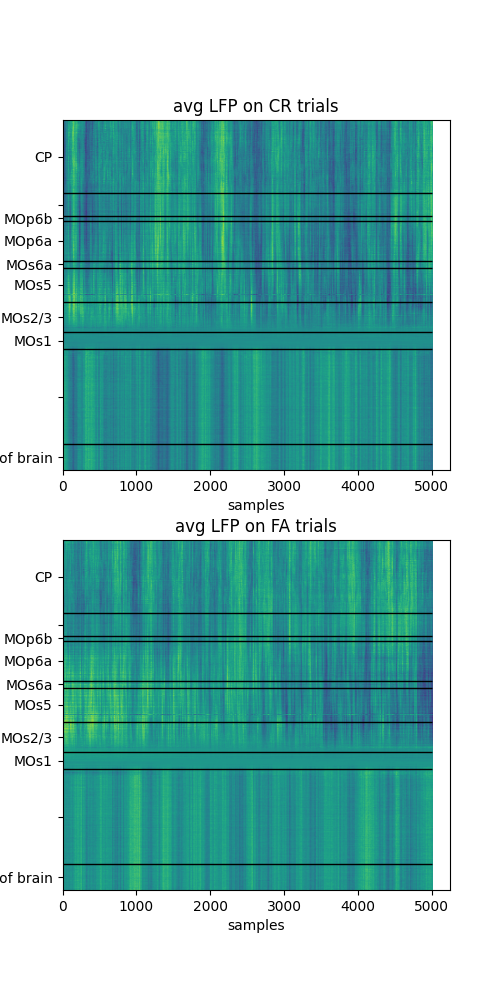

[Text(0, 40.0, 'CP'),
 Text(0, 92.5, ''),
 Text(0, 107.5, 'MOp6b'),
 Text(0, 132.0, 'MOp6a'),
 Text(0, 158.0, 'MOs6a'),
 Text(0, 180.5, 'MOs5'),
 Text(0, 215.5, 'MOs2/3'),
 Text(0, 241.5, 'MOs1'),
 Text(0, 303.0, ''),
 Text(0, 369.5, 'out of brain')]

In [18]:
fig,ax=plt.subplots(2,1,figsize=(5,10))

cr_im=ax[0].imshow(CR_lfp.T,aspect='auto')
ax[0].set_title('avg LFP on CR trials')
# ax[0].set_xlim([0,100])
ax[0].set_ylabel('channel')
ax[0].set_xlabel('samples')

ax[0].hlines(area_borders,xmin=0,xmax=5000,
                   color='k',linewidth=1)
ax[0].set_yticks(midpoints)
ax[0].set_yticklabels(area_labels)

fa_im=ax[1].imshow(FA_lfp.T,aspect='auto')
ax[1].set_title('avg LFP on FA trials')
# ax[1].set_xlim([0,100])
ax[1].set_ylabel('channel')
ax[1].set_xlabel('samples')

ax[1].hlines(area_borders,xmin=0,xmax=5000,
                   color='k',linewidth=1)
ax[1].set_yticks(midpoints)
ax[1].set_yticklabels(area_labels)

<IPython.core.display.Javascript object>


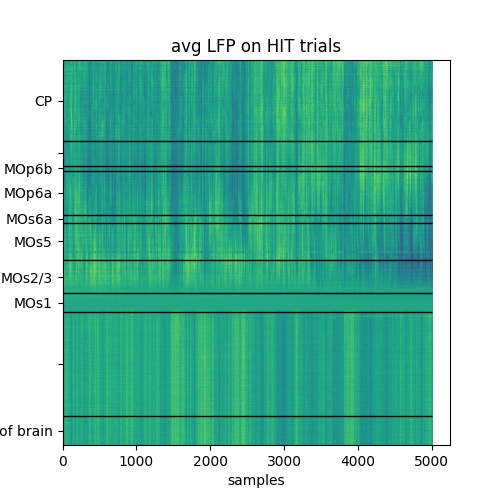

[Text(0, 40.0, 'CP'),
 Text(0, 92.5, ''),
 Text(0, 107.5, 'MOp6b'),
 Text(0, 132.0, 'MOp6a'),
 Text(0, 158.0, 'MOs6a'),
 Text(0, 180.5, 'MOs5'),
 Text(0, 215.5, 'MOs2/3'),
 Text(0, 241.5, 'MOs1'),
 Text(0, 303.0, ''),
 Text(0, 369.5, 'out of brain')]

In [20]:
fig,ax=plt.subplots(1,1,figsize=(5,5))

cr_im=ax.imshow(HIT_lfp.T,aspect='auto')
ax.set_title('avg LFP on HIT trials')
# ax[0].set_xlim([0,100])
ax.set_ylabel('channel')
ax.set_xlabel('samples')

ax.hlines(area_borders,xmin=0,xmax=5000,
                   color='k',linewidth=1)
ax.set_yticks(midpoints)
ax.set_yticklabels(area_labels)

<IPython.core.display.Javascript object>


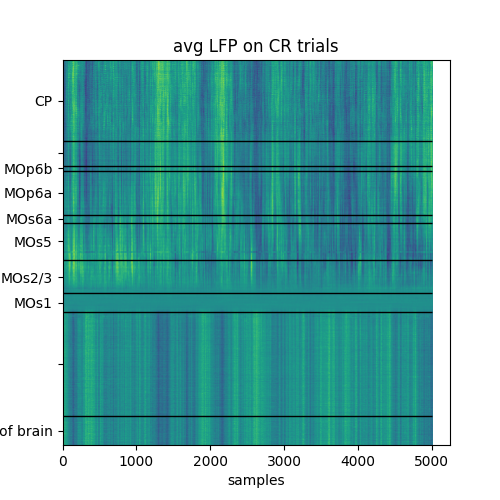

[Text(0, 40.0, 'CP'),
 Text(0, 92.5, ''),
 Text(0, 107.5, 'MOp6b'),
 Text(0, 132.0, 'MOp6a'),
 Text(0, 158.0, 'MOs6a'),
 Text(0, 180.5, 'MOs5'),
 Text(0, 215.5, 'MOs2/3'),
 Text(0, 241.5, 'MOs1'),
 Text(0, 303.0, ''),
 Text(0, 369.5, 'out of brain')]

In [21]:
fig,ax=plt.subplots(1,1,figsize=(5,5))

cr_im=ax.imshow(CR_lfp.T,aspect='auto')
ax.set_title('avg LFP on CR trials')
# ax[0].set_xlim([0,100])
ax.set_ylabel('channel')
ax.set_xlabel('samples')

ax.hlines(area_borders,xmin=0,xmax=5000,
                   color='k',linewidth=1)
ax.set_yticks(midpoints)
ax.set_yticklabels(area_labels)

<IPython.core.display.Javascript object>


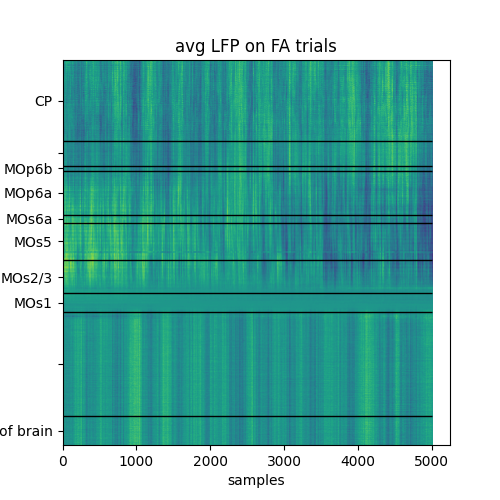

[Text(0, 40.0, 'CP'),
 Text(0, 92.5, ''),
 Text(0, 107.5, 'MOp6b'),
 Text(0, 132.0, 'MOp6a'),
 Text(0, 158.0, 'MOs6a'),
 Text(0, 180.5, 'MOs5'),
 Text(0, 215.5, 'MOs2/3'),
 Text(0, 241.5, 'MOs1'),
 Text(0, 303.0, ''),
 Text(0, 369.5, 'out of brain')]

In [22]:
fig,ax=plt.subplots(1,1,figsize=(5,5))

fa_im=ax.imshow(FA_lfp.T,aspect='auto')
ax.set_title('avg LFP on FA trials')
# ax[0].set_xlim([0,100])
ax.set_ylabel('channel')
ax.set_xlabel('samples')

ax.hlines(area_borders,xmin=0,xmax=5000,
                   color='k',linewidth=1)
ax.set_yticks(midpoints)
ax.set_yticklabels(area_labels)

In [ ]:
np.min(FA_power)

In [ ]:
np.max(CR_power[:100,:])

In [ ]:
session.trials

In [ ]:
np.round(sample_frequency*4).astype('int')

In [ ]:
session.trials

In [ ]:

startPt = int(sample_frequency*0)
endPt = startPt + int(sample_frequency)

channel_range = [350,360]

nchannels=384
nfft=4096

channels = np.arange(nchannels).astype('int')

chunk = np.copy(lfp_signal[startPt:endPt,channels])

for ch in np.arange(nchannels):
    chunk[:,ch] = chunk[:,ch] - np.median(chunk[:,ch])

for ch in np.arange(nchannels):
    chunk[:,ch] = chunk[:,ch] - np.median(chunk[:,channel_range[0]:channel_range[1]],1)

power = np.zeros((int(nfft/2+1), nchannels))

for ch in np.arange(nchannels):

    sample_frequencies, Pxx_den = sg.welch(chunk[:,ch], fs=sample_frequency, nfft=nfft)
    power[:,ch] = Pxx_den

In [ ]:
# #re-reference to acsf channels

# ACSF_chans=np.arange(325,350)

# lfp_re_ref_ch=lfp_channel_ind[::4]
# lfp_re_ref=[]
# lfp_re_ref=np.zeros((lfp_signal.shape[0],lfp_re_ref_ch.shape[0]))

# ACSF_median=np.median(lfp_signal[:,ACSF_chans],1)

# for ich, ch in enumerate(lfp_re_ref_ch):
#     lfp_re_ref[:,ich]=(lfp_signal[:,ch]-ACSF_median)
    

In [ ]:
# for ich, ch in enumerate(lfp_re_ref_ch):
#     print('ich: ',ich)
#     print('ch: ',ch)

In [ ]:
start_t=0
end_t=60
time_axis=np.arange(start_t,end_t,1/2500)
plot_data=chunk
# plot_data=lfp_re_ref
# plot_data=lfp_signal

fig,ax=plt.subplots()
im=ax.imshow(plot_data[2500*start_t:2500*end_t,:].T,aspect='auto',
            extent=(start_t,end_t,plot_data.shape[1],0),vmin=-2000,vmax=2000)

fig.subplots_adjust(bottom=0.1, right=0.8, top=0.9, hspace=0.3)
cax = plt.axes([0.85, 0.1, 0.025, 0.8])
cbar = fig.colorbar(im, cax=cax)

In [ ]:
### need surface estimate to get ACSF channels